In [2]:
import os
import math
import sys

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from hydra import initialize, compose


# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.analysis import ft, stats
from mejiro.plots import plot

# Set x-axis

NB this assumes both sets were generated 45 pixels on a side, 4.95 arcseconds

In [3]:
arcsec_min = 0.11
arcsec_max = 4.95

theta_array = ft.get_theta_list(arcsec_min, arcsec_max, 45)

# k_min = (2 * np.pi) / 4.95
# k_max = (2 * np.pi) / 0.11

# k_array = np.linspace(k_min, k_max, 45, endpoint=True)

# Different PSFs

In [4]:
no_psf = np.load(os.path.join(array_dir, 'sample_skypy_lens', 'no_psf.npy'))
gaussian_psf = np.load(os.path.join(array_dir, 'sample_skypy_lens', 'gaussian_psf.npy'))
webbpsf = np.load(os.path.join(array_dir, 'sample_skypy_lens', 'webbpsf.npy'))

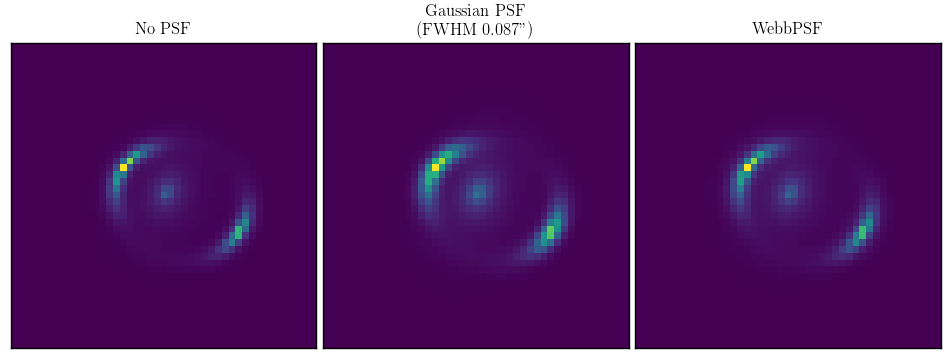

In [5]:
psf_title_list = ['No PSF', 'Gaussian PSF\n(FWHM 0.087\")', 'WebbPSF']
plot.plot_list([no_psf, gaussian_psf, webbpsf], title_list=psf_title_list)

In [6]:
power_no_psf = ft.power_spectrum(no_psf)
power_gaussian_psf = ft.power_spectrum(gaussian_psf)
power_webbpsf = ft.power_spectrum(webbpsf)

# Substructure

In [7]:
no_cut_masses = np.load(os.path.join(config.machine.data_dir, 'output', 'power_spectrum_galsim', 'no_cut_masses.npy'))
cut_7_masses = np.load(os.path.join(config.machine.data_dir, 'output', 'power_spectrum_galsim', 'cut_7_masses.npy'))
cut_8_masses = np.load(os.path.join(config.machine.data_dir, 'output', 'power_spectrum_galsim', 'cut_8_masses.npy'))

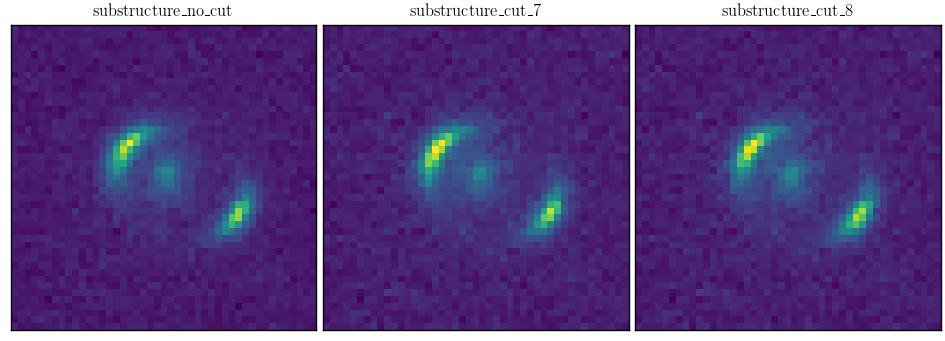

In [8]:
no_cut_image = np.load(os.path.join(config.machine.data_dir, 'output', 'power_spectrum_galsim', 'substructure_no_cut.npy'))
cut_7_image = np.load(os.path.join(config.machine.data_dir, 'output', 'power_spectrum_galsim', 'substructure_cut_7.npy'))
cut_8_image = np.load(os.path.join(config.machine.data_dir, 'output', 'power_spectrum_galsim', 'substructure_cut_8.npy'))

images = [no_cut_image, cut_7_image, cut_8_image]
titles = ['substructure_no_cut', 'substructure_cut_7', 'substructure_cut_8']

plot.plot_list(images, title_list=titles)

In [9]:
power_no_cut = ft.power_spectrum(no_cut_image)
power_cut_7 = ft.power_spectrum(cut_7_image)
power_cut_8 = ft.power_spectrum(cut_8_image)

# Plot

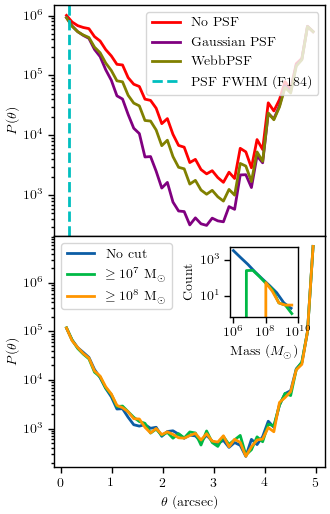

In [10]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(3.5, 6))

# remove vertical space between axes
fig.subplots_adjust(hspace=0)

ax[0].plot(theta_array, np.flip(power_no_psf), label='No PSF', color='red')
ax[0].plot(theta_array, np.flip(power_gaussian_psf), label='Gaussian PSF', color='purple')
ax[0].plot(theta_array, np.flip(power_webbpsf), label='WebbPSF', color='olive')
ax[0].axvline(0.151, label='PSF FWHM (F184)', color='c', linestyle='--')

# x1, x2, y1, y2 = 10, 40, 5 * 10 ** -5, 4 * 10 ** -3
# zoom_axes0 = ax[0].inset_axes(bounds=[0.05,0.05,0.5,0.5], xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
# zoom_axes0.loglog(k, power_no_psf, label='No PSF')
# zoom_axes0.loglog(k, power_gaussian_psf, label='Gaussian PSF')
# zoom_axes0.loglog(k, power_pandeia, label='WebbPSF')
# zoom_axes0.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
# ax[0].indicate_inset_zoom(zoom_axes0, edgecolor="black")

# ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel(r'$P(\theta)$')
ax[0].legend(loc='upper right')

ax[1].plot(theta_array, np.flip(power_no_cut), label='No cut')
ax[1].plot(theta_array, np.flip(power_cut_7), label='$\geq 10^7$ M$_\odot$')
ax[1].plot(theta_array, np.flip(power_cut_8), label='$\geq 10^8$ M$_\odot$')

n1, m1 = np.histogram(no_cut_masses, bins=np.logspace(6, 10, 10))
n2, m2 = np.histogram(cut_7_masses, bins=np.logspace(6, 10, 11))
n3, m3 = np.histogram(cut_8_masses, bins=np.logspace(6, 10, 11))

inset_axes = ax[1].inset_axes(bounds=[0.65,0.65,0.25,0.3])
inset_axes.loglog(m1[0:-1], n1)
inset_axes.loglog(m2[0:-1], n2)
inset_axes.loglog(m3[0:-1], n3)
# inset_axes.set_ylim(-1, 0.1)
inset_axes.set_xticks([10 ** 6, 10 ** 8, 10 ** 10])
inset_axes.set_xlabel('Mass '+r'($M_{\odot}$)')
inset_axes.set_ylabel('Count')

# x1, x2, y1, y2 = 0.1, 0.14, 1 * 10 ** 5, 1.25 * 10 ** 5
# zoom_axes = ax[1].inset_axes(bounds=[0.25,0.35,0.25,0.3], xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
# zoom_axes.plot(theta_array, np.flip(power_no_cut), label='No cut')
# zoom_axes.plot(theta_array, np.flip(power_cut_7), label='$\geq 10^7$ M$_\odot$')
# zoom_axes.plot(theta_array, np.flip(power_cut_8), label='$\geq 10^8$ M$_\odot$')
# zoom_axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
# ax[1].indicate_inset_zoom(zoom_axes, edgecolor="black")

# ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel(r'$\theta$ (arcsec)')
# ax[1].set_xticks([10 ** 0, 10 ** 1])
ax[1].set_ylabel(r'$P(\theta)$')
ax[1].legend(loc='upper left')

plt.savefig(os.path.join(figure_dir, 'power_spectra.png'))